In [4]:
import os
import cv2
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [5]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
path='/content/drive/My Drive/fire_dataset/fire_dataset'
pd.DataFrame(os.listdir(path),columns=['Files'])

Files
0      fire_images
1  non_fire_images

from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('Files').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [7]:
train_data_dir =path
batch_size = 32
target_size = (224, 224)
validation_split = 0.2
train= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=44,
    image_size=target_size,
    batch_size=batch_size,
)

Found 999 files belonging to 2 classes.
Using 800 files for training.
Found 999 files belonging to 2 classes.
Using 199 files for validation.


In [9]:
class_names = train.class_names
class_names

['fire_images', 'non_fire_images']

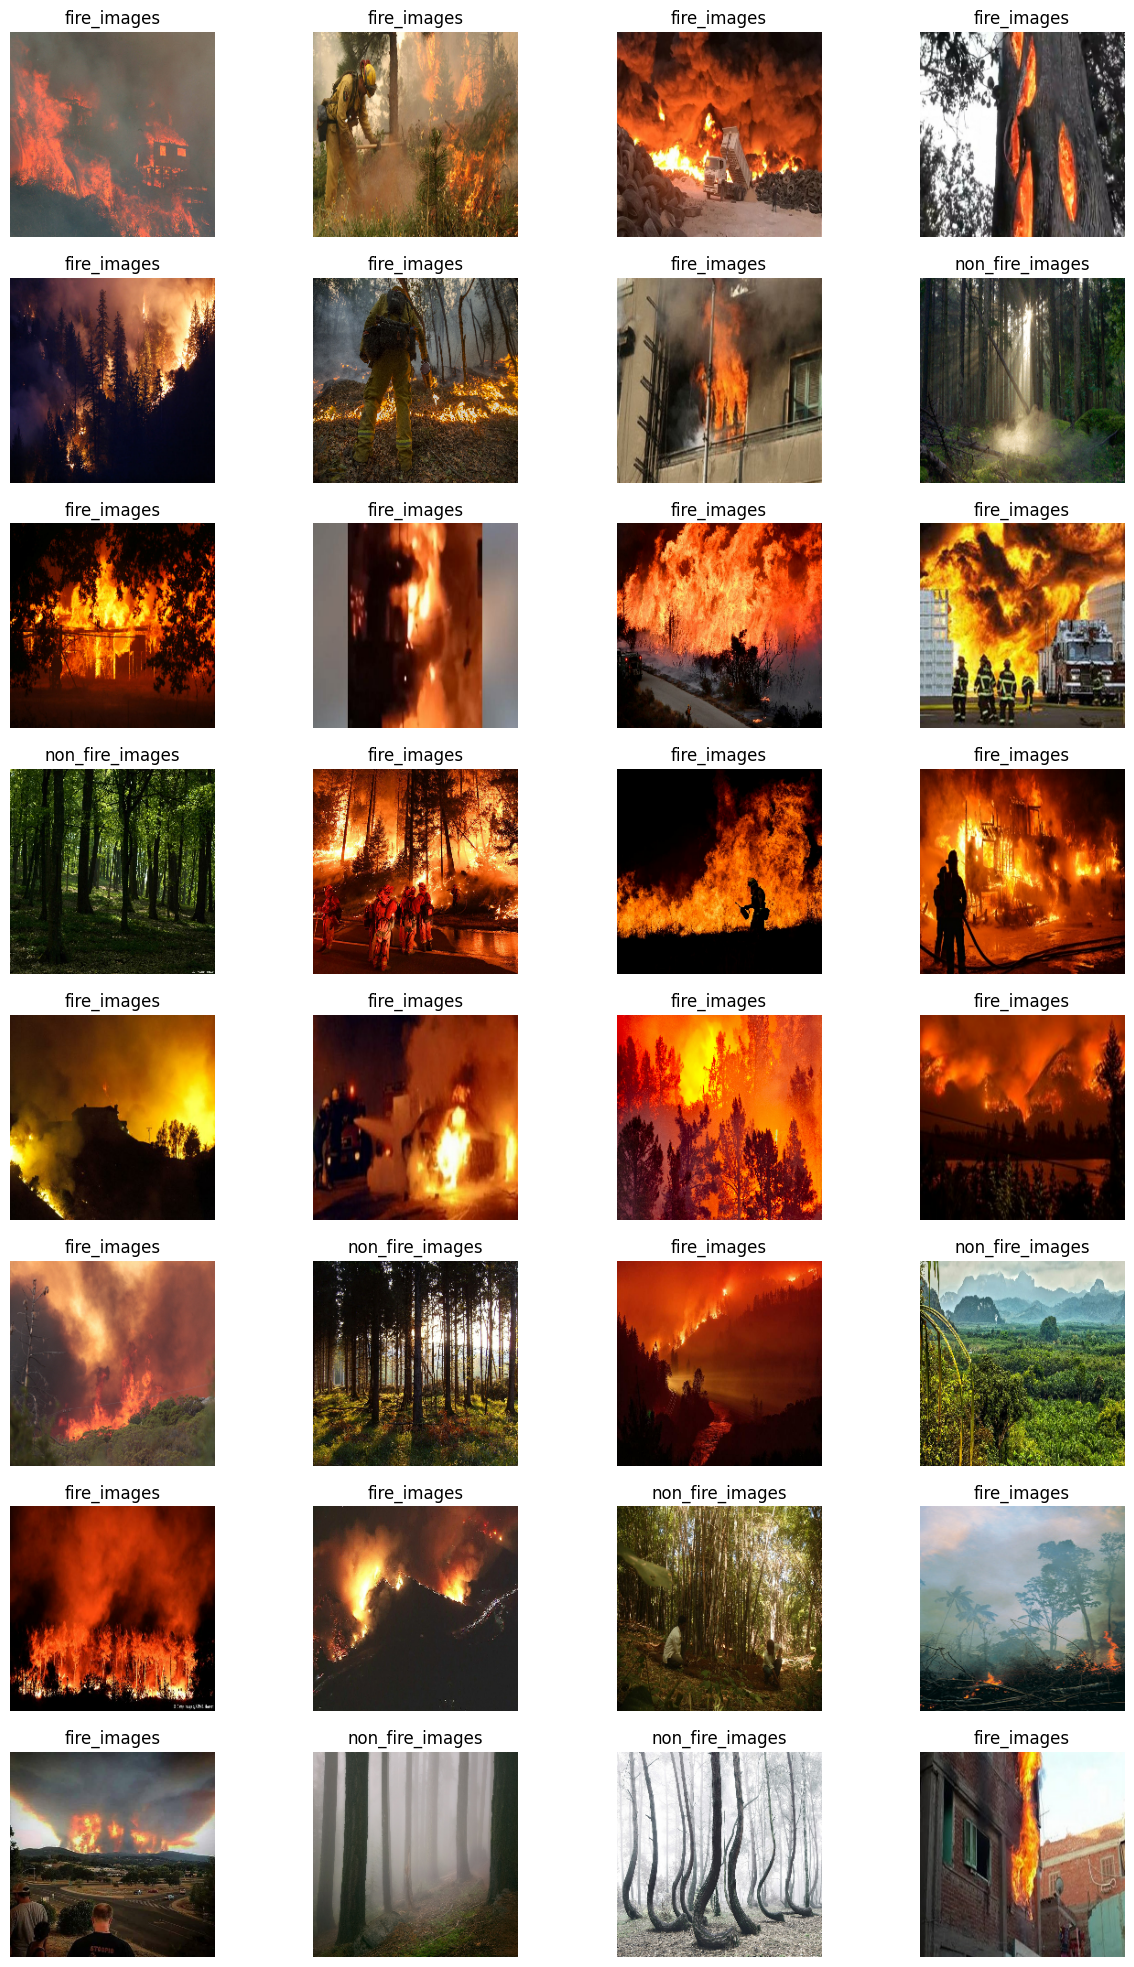

In [10]:
plt.figure(figsize=(15, 25))
for images, labels in train.take(1):
    for i in range(32):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')
base_model.trainable = False
model=keras.models.Sequential()
model.add(base_model)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(.2))
model.add(keras.layers.Dense(1,activation=tf.nn.sigmoid))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14739777 (56.23 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


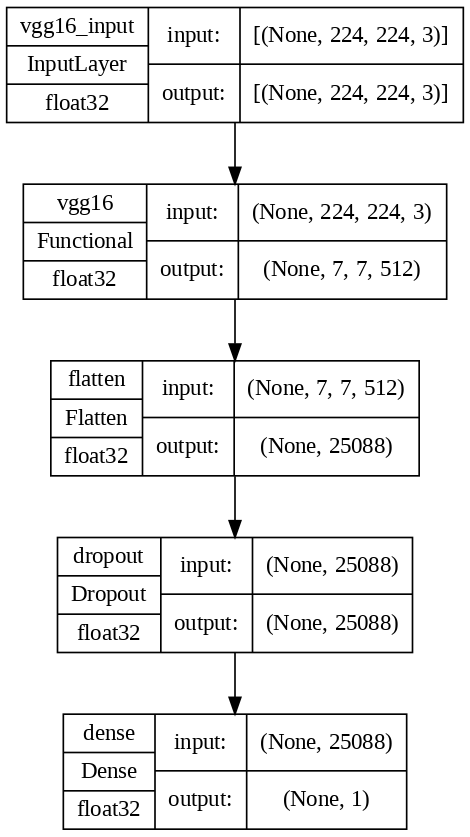

In [12]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [14]:
checkpoint_cb =ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=3, restore_best_weights=True)
model.compile(optimizer ='adam',loss='binary_crossentropy', metrics=['accuracy'])
hist=model.fit_generator(train,epochs=20,validation_data=validation,callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/20
25/25 [==============================] - 610s 24s/step - loss: 0.1394 - accuracy: 0.9812 - val_loss: 0.2816 - val_accuracy: 0.9749
Epoch 2/20
25/25 [==============================] - 616s 25s/step - loss: 0.0310 - accuracy: 0.9925 - val_loss: 0.3375 - val_accuracy: 0.9849
Epoch 3/20
25/25 [==============================] - 609s 24s/step - loss: 0.0534 - accuracy: 0.9962 - val_loss: 0.2940 - val_accuracy: 0.9849
Epoch 4/20
25/25 [==============================] - 602s 24s/step - loss: 0.0609 - accuracy: 0.9962 - val_loss: 0.4238 - val_accuracy: 0.9799


In [15]:
score, acc = model.evaluate(validation)
print('Test Loss =', score)
print('Test Accuracy =', acc)

7/7 [==============================] - 114s 15s/step - loss: 0.2816 - accuracy: 0.9749
Test Loss = 0.2816297113895416
Test Accuracy = 0.9748743772506714


In [16]:
hist_=pd.DataFrame(hist.history)
hist_

loss  accuracy  val_loss  val_accuracy
0  0.139433   0.98125  0.281630      0.974874
1  0.030963   0.99250  0.337535      0.984925
2  0.053380   0.99625  0.294011      0.984925
3  0.060888   0.99625  0.423800      0.979900

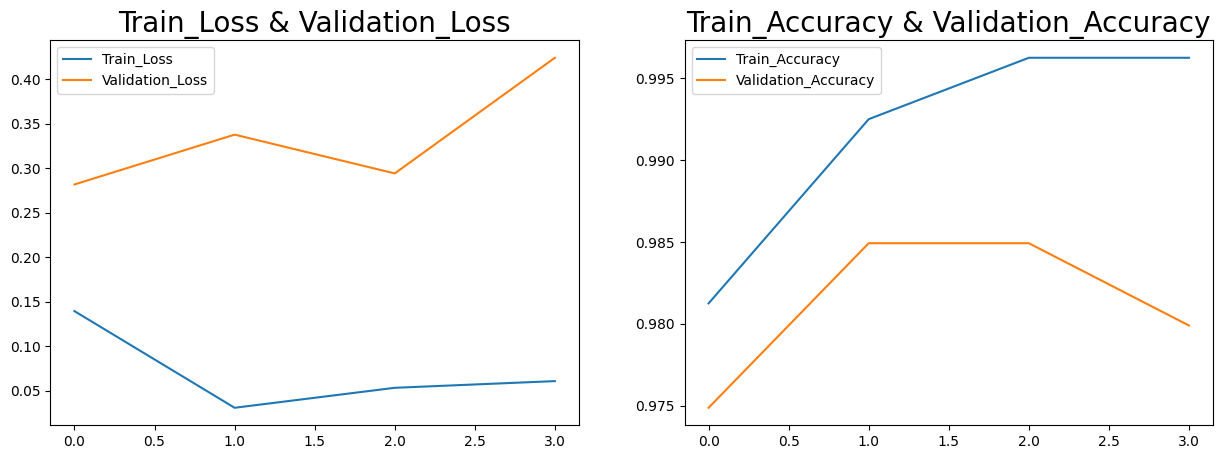

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [18]:
X_val,y_val=[],[]
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=model.predict(np.array(X_val))
y_pred=np.where(predictions>=.5,1,0)
df=pd.DataFrame()
df['Actual'],df['Prediction']=y_val,y_pred
df

7/7 [==============================] - 119s 17s/step


Actual  Prediction
0         0           0
1         0           0
2         1           1
3         0           0
4         0           0
..      ...         ...
194       0           0
195       0           0
196       0           0
197       1           1
198       0           0

[199 rows x 2 columns]

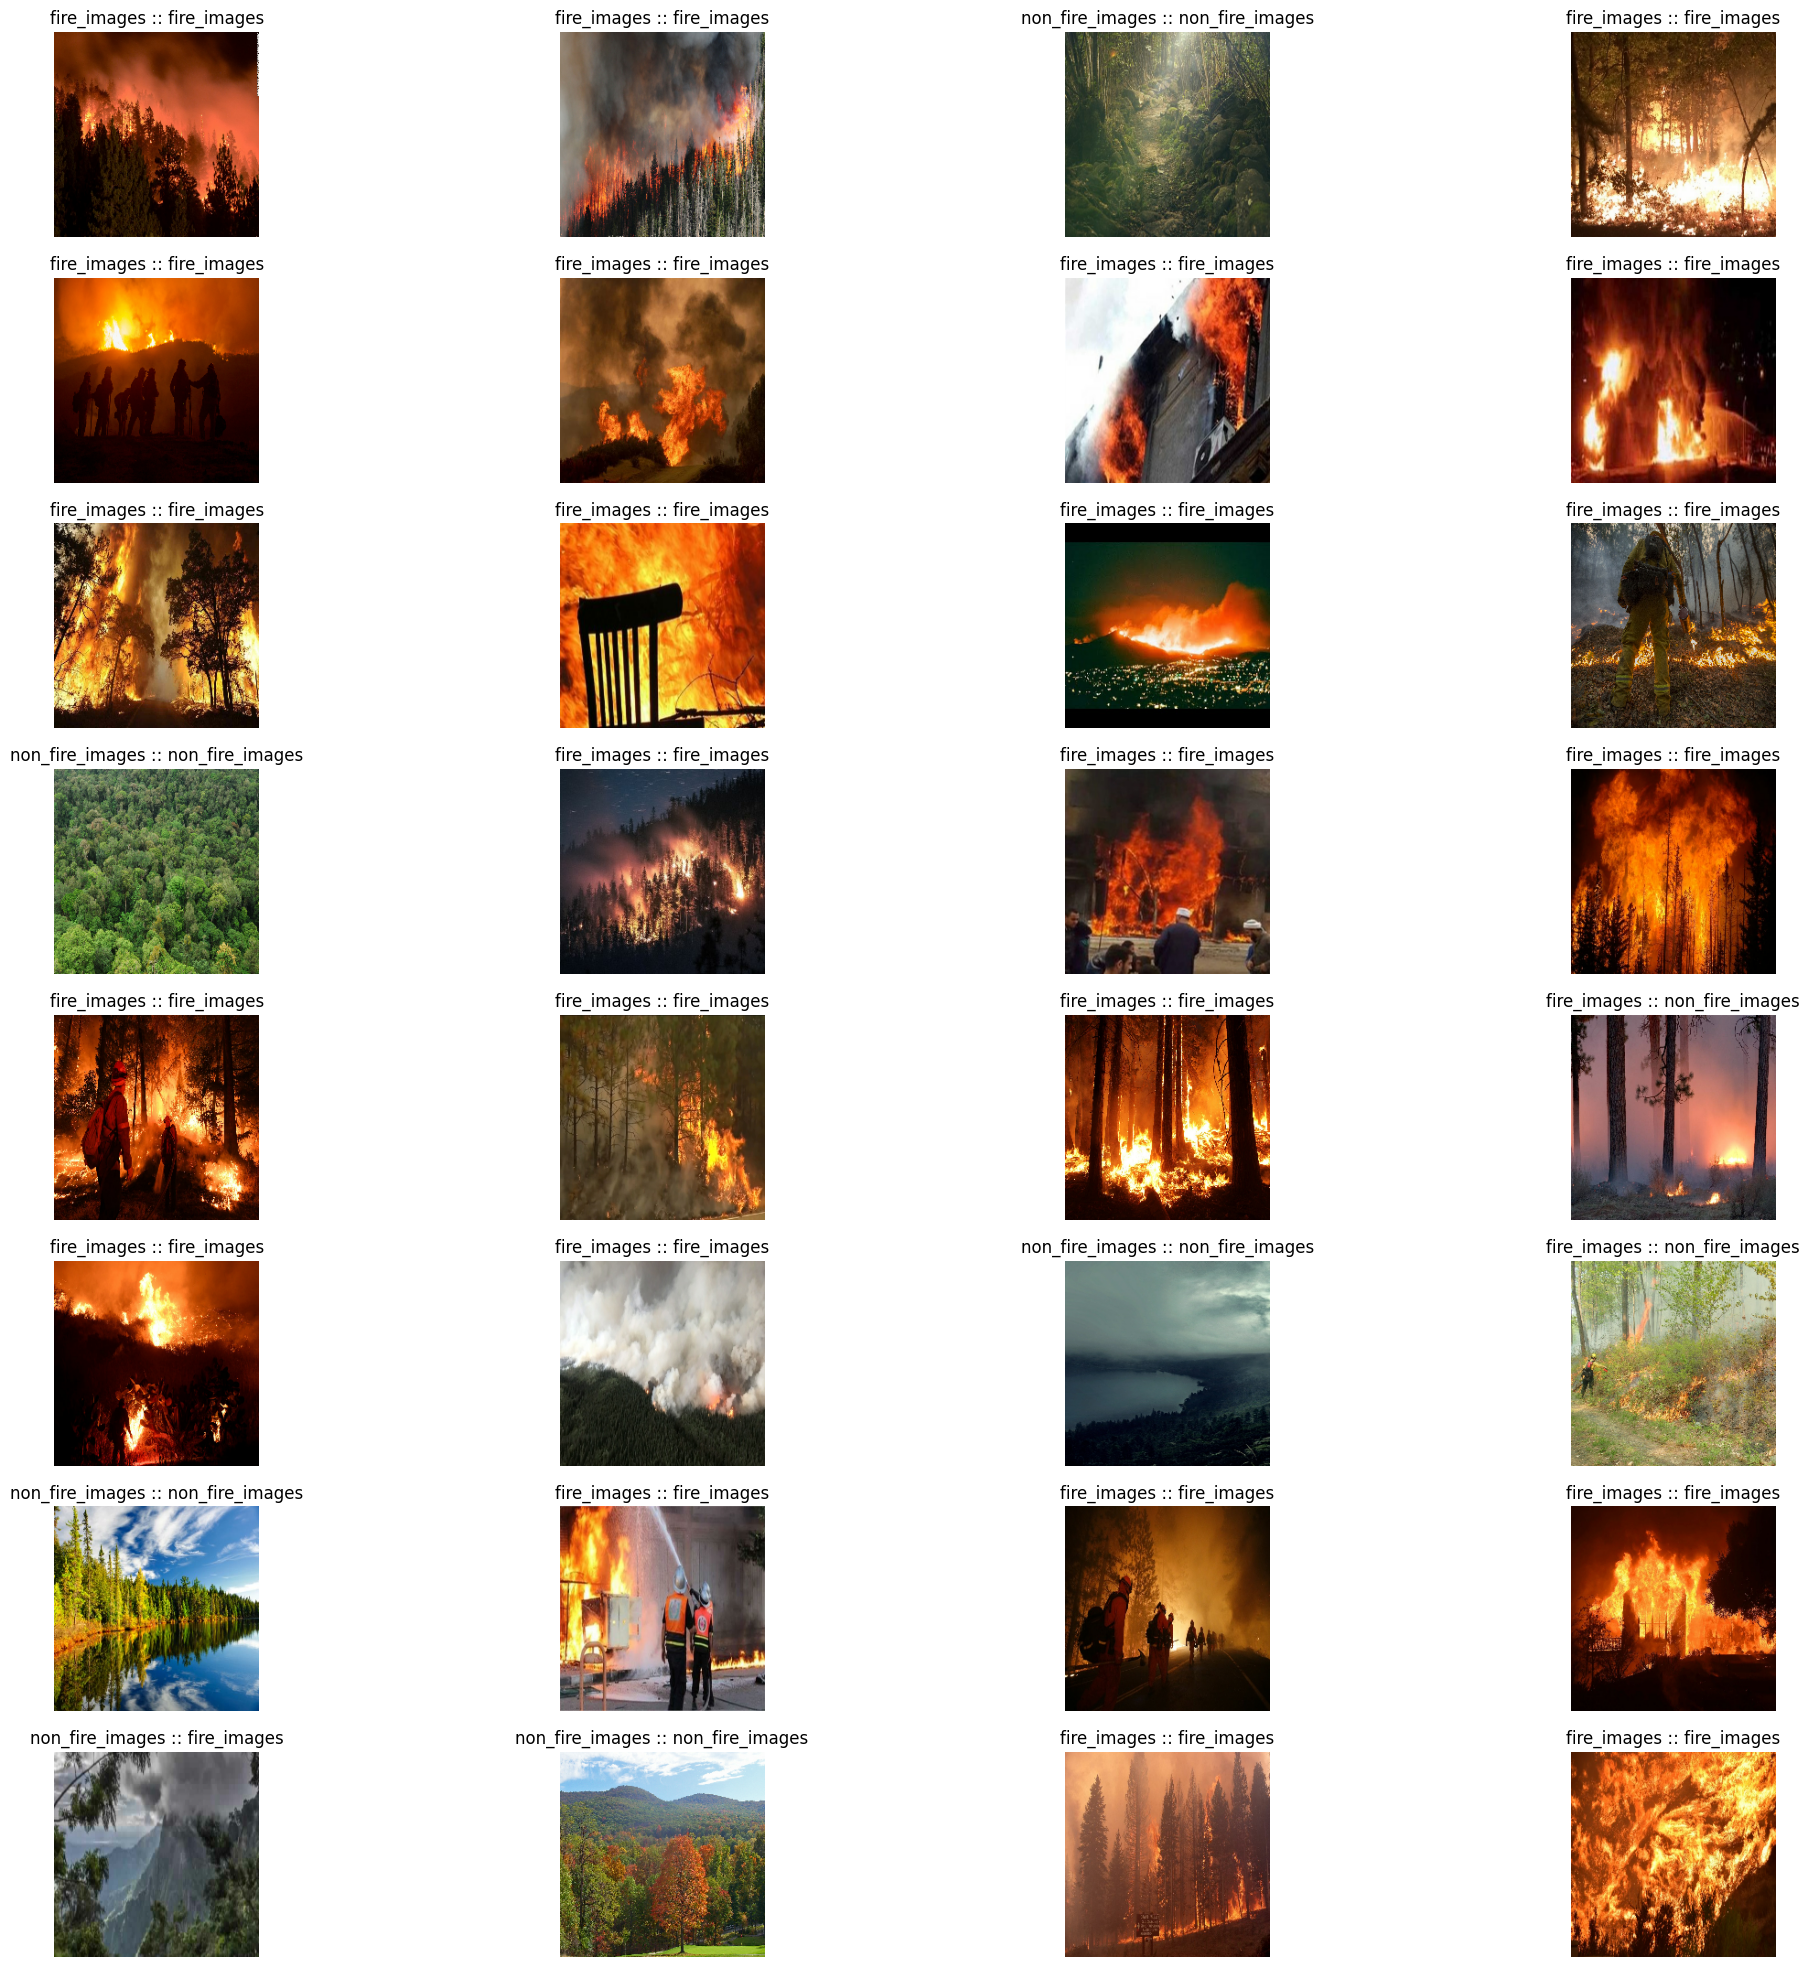

In [19]:
plt.figure(figsize=(25,25))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i][0]]}')
    plt.axis("off")

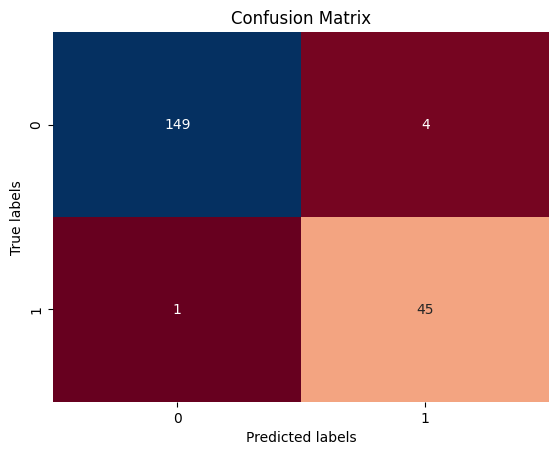

array([[149,   4],
       [  1,  45]])

In [20]:
ax= plt.subplot()
CM = confusion_matrix(y_val,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()
CM

In [21]:
ClassificationReport = classification_report(y_val,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.99      0.97      0.98       153
           1       0.92      0.98      0.95        46

    accuracy                           0.97       199
   macro avg       0.96      0.98      0.97       199
weighted avg       0.98      0.97      0.98       199



In [ ]:
def Test(path):
    save_model = keras.models.load_model('/kaggle/working/my_keras_model.h5')
    images = []
    pred = []
    class_names = ['fire_images', 'non_fire_images']
    for img in os.listdir(path):
        image = cv2.imread(os.path.join(path, img))
        image = cv2.resize(image, (224, 224))
        image =cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        images.append(image)
        image = np.expand_dims(image, axis=0)
        predict = save_model.predict(image)
        pred.append(np.where(predict >= 0.5, 1, 0))
    plt.figure(figsize=(25, 25))
    for i in range(len(pred)):
        plt.subplot(int(np.ceil(len(pred) / 2)), 2, i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.title(f'{class_names[pred[i][0][0]]}')
        plt.axis("off")
    plt.show()

Test('/kaggle/input/test-iamge')